# Credit Risk Prediction

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from sklearn.linear_model import LogisticRegression

### 1. Chargement et petite analyse des données

In [2]:
df = pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
# Forme du tableau
df.shape

(32581, 12)

In [4]:
# Informations importantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
# Valeurs manquantes 
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

**Il y'a énormément de valeurs manquantes qui seront traités plus tard**

### 2. Analyse exploratoire 

<Figure size 640x480 with 0 Axes>

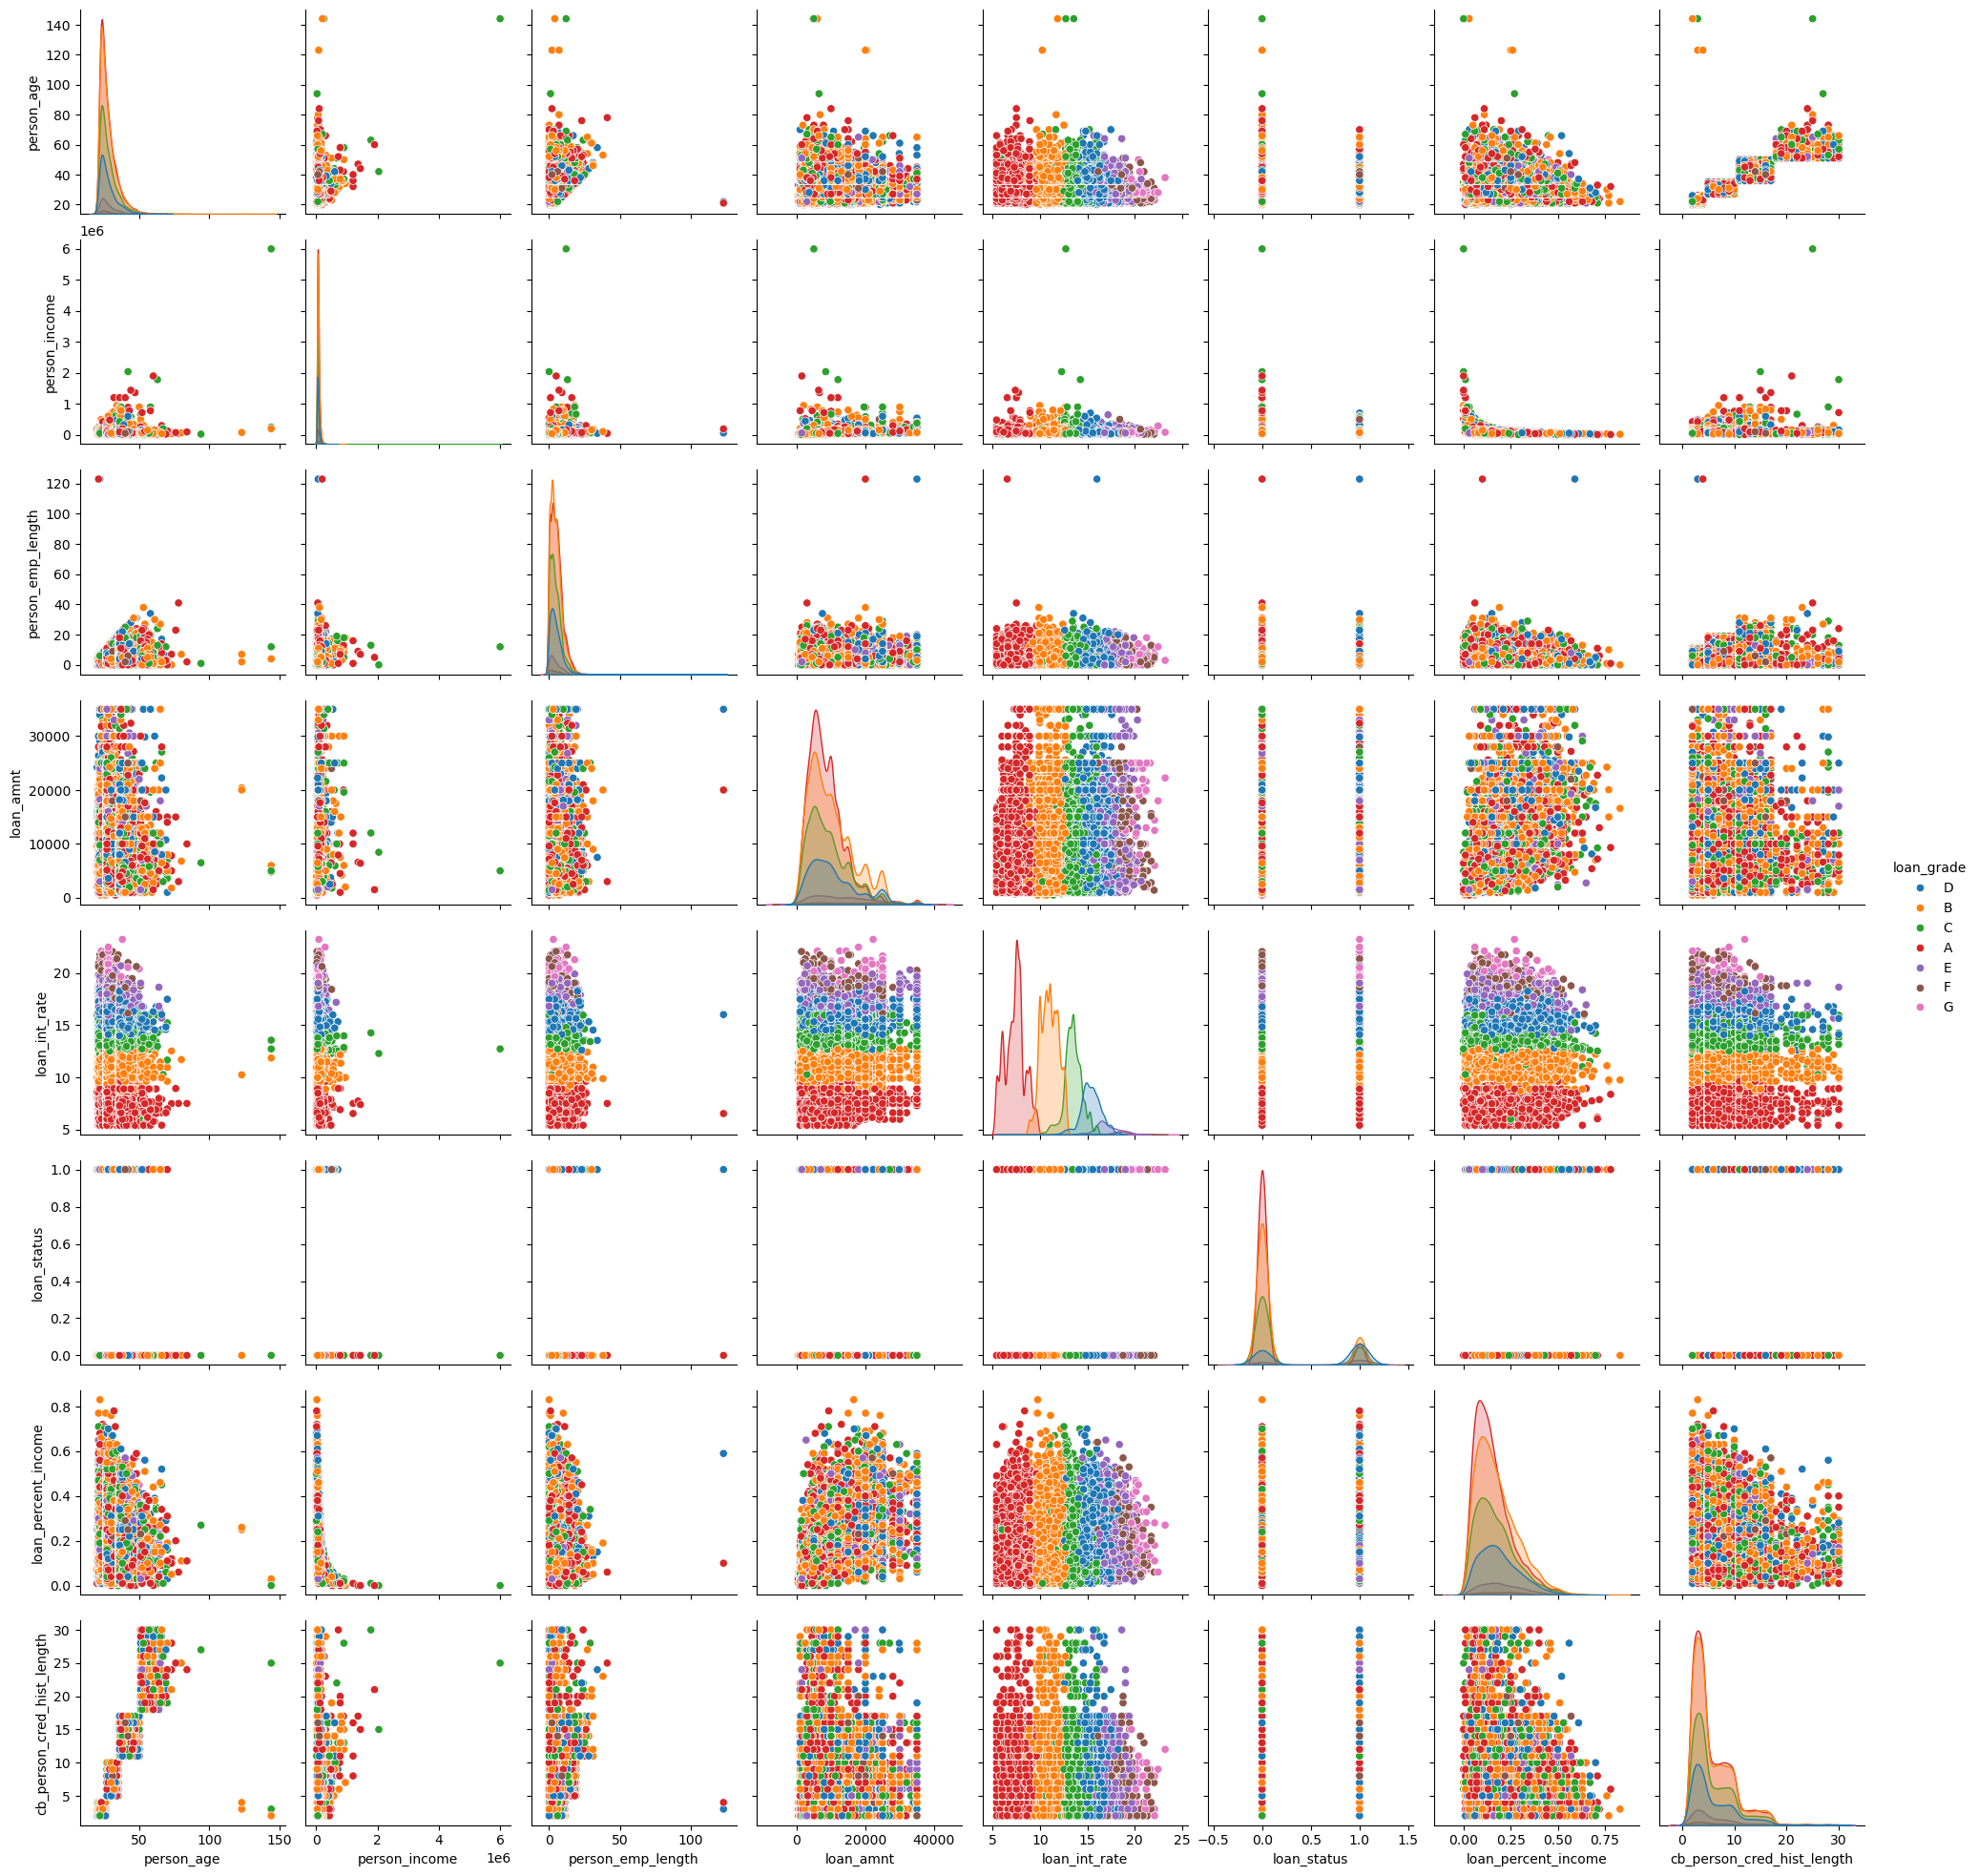

In [6]:
# Vue d'ensemble sur les relations entre les différentes variables 
plt.figure()
sns.pairplot(df, hue = 'loan_grade')
plt.savefig('credit.png')

**Visualisation de quelques distributions**

<Axes: xlabel='loan_status', ylabel='Count'>

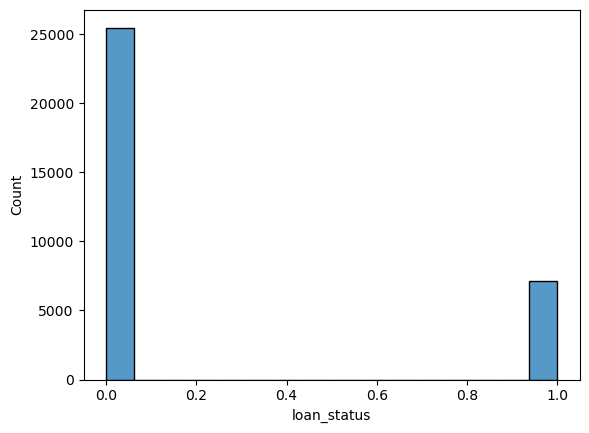

In [7]:
sns.histplot(df['loan_status'])

<Axes: xlabel='loan_grade', ylabel='Count'>

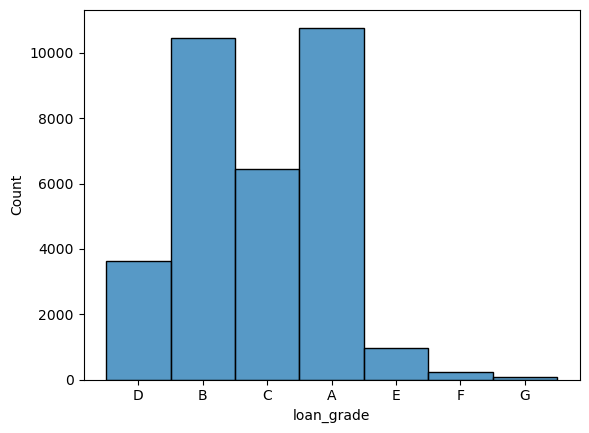

In [8]:
sns.histplot(df['loan_grade'])

<Axes: xlabel='loan_intent', ylabel='Count'>

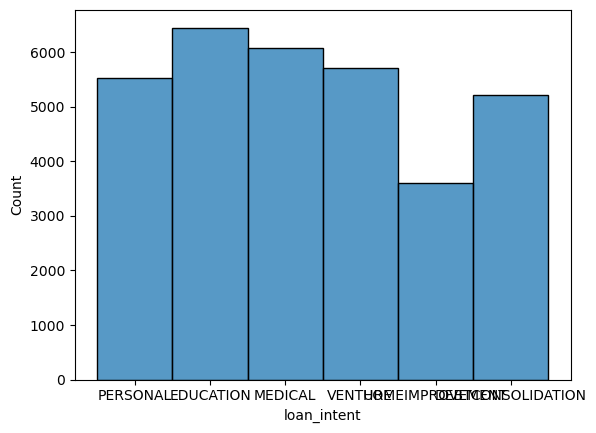

In [9]:
sns.histplot(df['loan_intent'])

<Axes: xlabel='person_home_ownership', ylabel='person_age'>

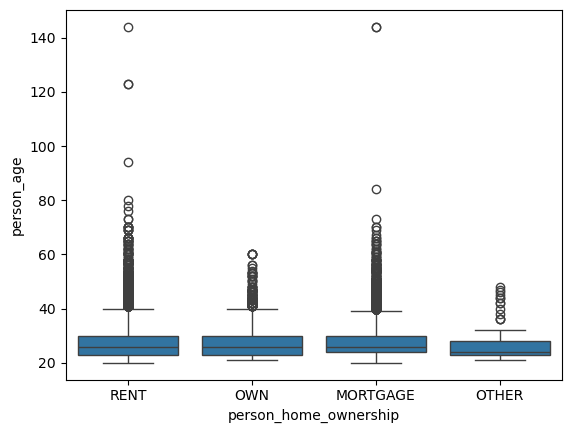

In [10]:
sns.boxplot(x = df['person_home_ownership'], y = df['person_age'])

<Axes: xlabel='person_age', ylabel='person_income'>

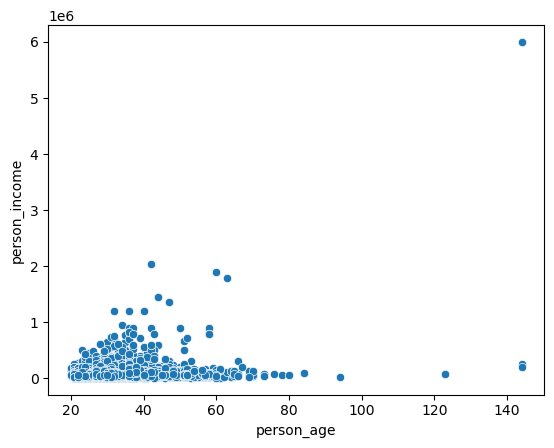

In [11]:
# Relations entre certaines variables 
sns.scatterplot(x = df['person_age'], y = df['person_income'])

<Axes: xlabel='loan_amnt', ylabel='loan_int_rate'>

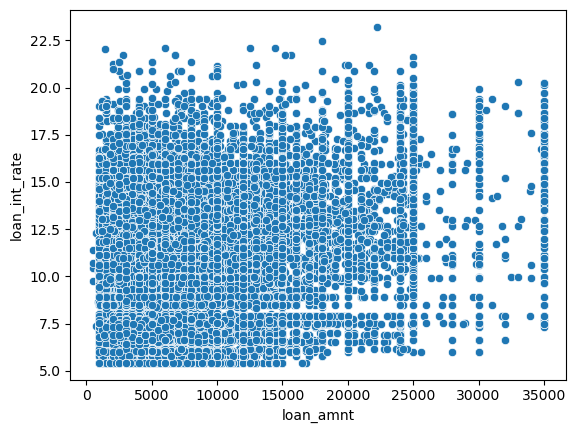

In [12]:
sns.scatterplot(x = df['loan_amnt'], y = df['loan_int_rate'])

In [13]:
# Vérification des corrélations entre les variables numériques 
num_features = df.select_dtypes(exclude=object)
corr = num_features.corr()
corr

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
person_age,1.000000,0.173202,0.163106,0.050787,0.012580,-0.021629,-0.042411,0.859133
person_income,0.173202,1.000000,0.134268,0.266820,0.000792,-0.144449,-0.254471,0.117987
person_emp_length,0.163106,0.134268,1.000000,0.113082,-0.056405,-0.082489,-0.054111,0.144699
loan_amnt,0.050787,0.266820,0.113082,1.000000,0.146813,0.105376,0.572612,0.041967
loan_int_rate,0.012580,0.000792,-0.056405,0.146813,1.000000,0.335133,0.120314,0.016696
loan_status,-0.021629,-0.144449,-0.082489,0.105376,0.335133,1.000000,0.379366,-0.015529
loan_percent_income,-0.042411,-0.254471,-0.054111,0.572612,0.120314,0.379366,1.000000,-0.031690
cb_person_cred_hist_length,0.859133,0.117987,0.144699,0.041967,0.016696,-0.015529,-0.031690,1.000000


<Axes: >

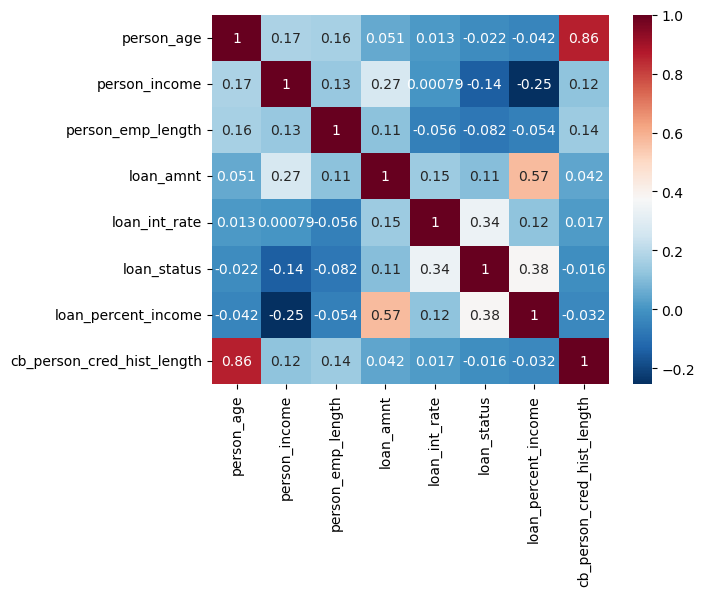

In [14]:
# Matrice de corrélation
sns.heatmap(corr, annot=True, cmap='RdBu_r')

### 3. Nettoyage et Preprocessing 

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer

In [16]:
# Création de l'imputer 
imputer = SimpleImputer(strategy='median')
imputer

SimpleImputer(strategy='median')

In [17]:
# Valeurs manquantes 
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [18]:
# Remplacer les données manquantes 
df['person_emp_length'] = imputer.fit_transform(df[['person_emp_length']])
df['loan_int_rate'] = imputer.fit_transform(df[['loan_int_rate']])

In [19]:
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

**Plus de valeurs manquantes**

In [20]:
# Traiter séparement les valeurs quantitatives et qualitatives
num_features= ['person_age', 'person_income', 'person_emp_length', 
               'loan_amnt','loan_int_rate', 'loan_percent_income',
               'cb_person_cred_hist_length']
cat_features = ['person_home_ownership', 'loan_intent', 
                'loan_grade','cb_person_default_on_file']
preprocessor = ColumnTransformer(
    transformers =[
        ('num', RobustScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ]
)        

### 4. Modélisation

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('logistic', LogisticRegression())
])
x = df.drop('loan_status', axis=1)
y = df['loan_status']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [22]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat', OneHotEncoder(),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('logistic', LogisticRegression())])

In [23]:
# Evaluation de ses performances sur le train test
pipe.score(x_train, y_train)

0.8666743400859422

**Très bon pouvoir de prédiction sur des données qu'il connaît dejà**

In [24]:
# Evaluation sur le test set
pipe.score(x_test, y_test)

0.8649685438085009

**Encore un très bon pouvoir de prédiction alors essayons de trouver les meilleures hyperparamètres pour de meilleures prédictions**

In [25]:
# Vérifications du nombres de classe pour notre prédiction
y.value_counts()

loan_status
0    25473
1     7108
Name: count, dtype: int64

**Vue l'écart significatif présent entre les deux solutions possibles, nous allons utiliser le Stratified KFold pour un bon équilibre des classes**

In [26]:
from sklearn.model_selection import StratifiedKFold

In [27]:
# Chercher les meilleures hyperparamètres pour notre modèle afin d'avoir les meilleures prédictions possibles
param_grid = {
    'logistic__C' : [0.01, 0.1, 1, 10, 100, 1000],
    'logistic__max_iter' : [100, 200, 500, 1000, 2000]
}
cv = StratifiedKFold(5)
model = GridSearchCV(pipe, param_grid, cv = cv)

In [28]:
model.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         RobustScaler(),
                                                                         ['person_age',
                                                                          'person_income',
                                                                          'person_emp_length',
                                                                          'loan_amnt',
                                                                          'loan_int_rate',
                                                                          'loan_percent_income',
                                                                          'cb_person_cred_hist_length']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['person_home_ownership',
                                                                          'loan_intent',
                                                                          'loan_grade',
                                                                          'cb_person_default_on_file'])])),
                                       ('logistic', LogisticRegression())]),
             param_grid={'logistic__C': [0.01, 0.1, 1, 10, 100, 1000],
                         'logistic__max_iter': [100, 200, 500, 1000, 2000]})

In [29]:
model.best_params_

{'logistic__C': 100, 'logistic__max_iter': 100}

**Les meilleurs hyperparamètres pour notre modèle**

### 5. Evaluation du modèle

In [30]:
from sklearn.metrics import (
accuracy_score, 
precision_score, 
recall_score, 
f1_score,
confusion_matrix,
ConfusionMatrixDisplay,
roc_curve,
roc_auc_score
)

In [31]:
y_pred = model.predict(x_test)
accuracy = round(accuracy_score(y_test, y_pred),2)
precision = round(precision_score(y_test, y_pred),2)
recall = round(recall_score(y_test, y_pred),2)
f1_score = round(f1_score(y_test, y_pred),2)

In [32]:
print(f" Accuracy = {accuracy}")
print(f" Precision = {precision}")
print(f" Recall = {recall}")
print(f" f1_score = {f1_score}")

 Accuracy = 0.86
 Precision = 0.76
 Recall = 0.56
 f1_score = 0.64


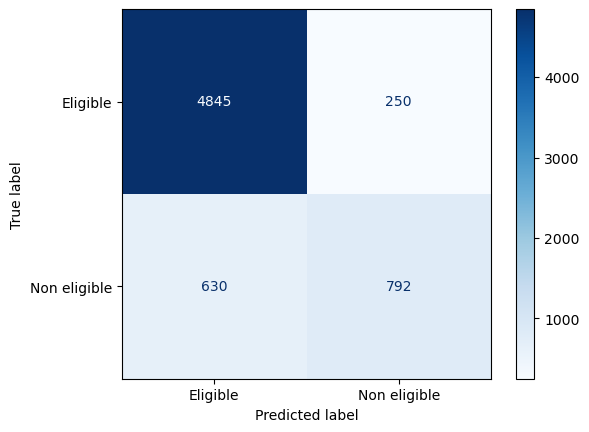

In [33]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
cm_disp = ConfusionMatrixDisplay(
    cm, display_labels=['Eligible', 'Non eligible']
)
cm_disp.plot(cmap='Blues')

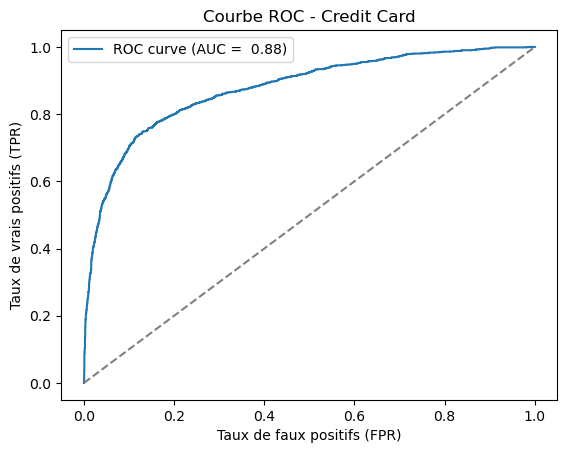

In [34]:
# ROC Curve et AUC
y_pred_proba = model.predict_proba(x_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc= roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc : .2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Credit Card')
plt.legend()

In [35]:
# Rapport de classification
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names= ['Eligible', 'Non eligible']))

              precision    recall  f1-score   support

    Eligible       0.88      0.95      0.92      5095
Non eligible       0.76      0.56      0.64      1422

    accuracy                           0.86      6517
   macro avg       0.82      0.75      0.78      6517
weighted avg       0.86      0.86      0.86      6517

